In [10]:
# Torch imports
from torch.utils.data import DataLoader

# Custom imports
import torch
import heuristics
from dataset_utils import PathPlanningDataset
from classic_astar import Astar
from training_module import NeuralAstarTrainingModule
from neural_astar import NeuralAstar
import lightning as pl
from differentiable_astar import DifferentiableAstar
import encoders

In [11]:
# Dataset Generation

initial_dataset = PathPlanningDataset(
    "/workspaces/datasets/raw/street",
    16,
    1,
    heuristics.euclidean,
    randomize_points=False,
    max_astar_iterations=10000,
)

training_dataloader = DataLoader(
    initial_dataset, batch_size=10, shuffle=True, drop_last=True, num_workers=7
)  # TODO fix for batch_size = 1

In [12]:
# Create Astar instances
classic_astar = Astar(
    heuristic=heuristics.euclidean, costmap_weight=5, heuristic_weight=5
)
differentiable_astar = DifferentiableAstar(max_iterations=5000, costmap_weight=10)

In [13]:
import segmentation_models_pytorch

unet = segmentation_models_pytorch.Unet(
    encoder_name="resnet18",
    encoder_depth=3,
    encoder_weights=None,
    decoder_channels=[2, 4, 8],
    in_channels=2,
    classes=1,
)

cnn = encoders.CNN(2, 4)
astar_encoder = encoders.AstarEncoder()
astar_encoder.add_encoder(cnn)

In [14]:
neural_astar = NeuralAstar(
    classic_astar=classic_astar,
    differentiable_astar=differentiable_astar,
    encoder=astar_encoder,
    use_start_goal_data=True,
)

In [15]:
astar_training_module = NeuralAstarTrainingModule(neural_astar=neural_astar)

In [16]:
trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    log_every_n_steps=1,
    default_root_dir="../logs/",
    max_epochs=100,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(astar_training_module, training_dataloader)


  | Name          | Type        | Params
----------------------------------------------
0 | neural_astar_ | NeuralAstar | 391 K 
----------------------------------------------
391 K     Trainable params
9         Non-trainable params
391 K     Total params
1.566     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 9/9 [00:01<00:00,  8.98it/s, v_num=1, train_loss=0.0162] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 9/9 [00:01<00:00,  8.87it/s, v_num=1, train_loss=0.0162]


torch.Size([10, 1, 16, 16])


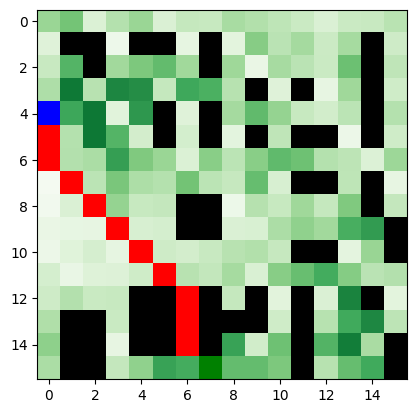

In [18]:
from display import Displayer
import matplotlib.pyplot as plt

map_batch, start_batch, goal_batch, path_batch = next(iter(training_dataloader))
map_batch = map_batch.unsqueeze(1)
start_batch = start_batch.unsqueeze(1)
goal_batch = goal_batch.unsqueeze(1)


print(map_batch.shape)

cosmtap_batch = neural_astar._get_cost_batch(map_batch, start_batch + goal_batch)
cosmtap_batch = cosmtap_batch.detach()
out_path, out_searched = neural_astar(map_batch, start_batch, goal_batch)

d = Displayer()
d.draw_full_astar_output(
    map_batch[0, 0],
    start_batch[0, 0],
    goal_batch[0, 0],
    out_searched[0, 0],
    out_path[0, 0],
    cosmtap_batch[0, 0],
)